# <center>Big Data &ndash; Exercises</center>
## <center>Autumn 2024 &ndash; Week 5 &ndash; ETH Zurich</center>
## <center>Wide Column Stores - HBase</center>

This exercise will consist of three main parts. You will:
* Create your own HBase cluster, fill it with data, and run basic queries.
* Get hands-on practice with HBase using the Wikipedia dataset.
* Get familiar with HFile indexes.

<font color='red'>Important note: If you are using a ARM based Mac, do the following steps before running docker compose up -d:</font>
1. delete the original `docker-compose.yml` file
2. rename  `docker-compose-aarch64.yml` to `docker-compose.yml`

# Exercise 1 &mdash; Creating and using an HBase cluster

It's time to touch HBase! You will create, fill with data, and query an HBase cluster running on Docker.

## Task 1.1: set up your HBase cluster using Docker:


0. Please first get the folder from GitHub containing all the necessary files that configure Docker. Please also open Docker, you should see that docker is active with green on the UI of Docker desktop. <br>


1. In the command line, navigate into your exercise05 folder using 'cd' command and instantiate the cluster by running:<br>**`docker compose up -d`**<br>Note that for the first time, it might take a little bit longer to set things up, as docker might need to pull the new images.
<img src="https://cloud.inf.ethz.ch/s/XCSGSssJkbnxFtJ/download">


2. List the container names with <br>**`docker ps --format "{{.Names}}"`**<br>
<img src="https://cloud.inf.ethz.ch/s/NJ4kj9stgAqTQfx/download">
<br>The names might slightly differ from system to system, depending on the setup. In this case, the master container is called <b><i>exercise05-hbase-master-1</i></b>. We will be using this to access the cluster, if the container is called something different, just change the name in the following commands accordingly :)


3. Copy the <b>.csv</b> data file from your local system to the docker container (the hbase-master) where hbase is running using the command:<br>**`docker cp enwiki-20200920-pages-articles-multistream_small.csv exercise05-hbase-master-1:/`**<br>
This will be used in Exercise 2. <br>
<img src="https://cloud.inf.ethz.ch/s/nSSixGmpTJ8ZjKP/download">


4. Access your container's bash by running the following command:<br>**`docker exec -it exercise05-hbase-master-1 /bin/bash`**<br>
Once in the bash, you can list your files and check the presence of the .csv data file: <br>
<img src="https://cloud.inf.ethz.ch/s/NdqoXoW6yNTEJrn/download"> <br>


5. We will use the <b>.csv</b> file later to populate our database. For now, let's explore the basics of HBase in this playground. To start, run the following command in the container's bash:<br>**`hbase shell`**<br>
<img src="https://cloud.inf.ethz.ch/s/RkBE5yB7Tap7noR/download"> <br>

## Task 1.2: Interact with your HBase cluster using the shell

Now we will go through some basic HBase commands, in preparation for the exercise 2, where we will import a dataset from a .csv file and run queries against it. For now, we will populate HBase by hand using simple commands which were mentioned in the lecture.

Makse sure you have opened the HBase shell by running the following command:

**`hbase shell`**

Let's say we want to create an HBase table that will store sentences adhering to the structure <a href="https://en.wikipedia.org/wiki/Subject%E2%80%93verb%E2%80%93object_word_order"><b>subject-verb-object</b></a> (e.g., "I eat mangoes", "She writes books") in different languages. Here is a schema that we may use:

Table name = `sentences`
* Column family: `words`
  * column: `subject`
  * column: `verb`
  * column: `object`
* Column family: `info`
  * column: `language`

With the following command we can create such a table (a description of HBase shell commands is available [here](https://learnhbase.wordpress.com/2013/03/02/hbase-shell-commands/)):

**`create 'sentences', 'words', 'info'`**

You can see the schema of the table with this command:

**`describe 'sentences'`**

Let's insert some sentences into our table. We will put data cell by cell using the following command format <br>
    `put <table>, <rowId>, <columnFamily:columnQualifier>, <value>`:

**`put 'sentences', 'row1', 'words:subject', 'I'`**

**`put 'sentences', 'row1', 'words:verb', 'drink'`**

**`put 'sentences', 'row1', 'words:object', 'coffee'`**

Now, let's try to query this sentence from the table:

**`get 'sentences', 'row1'`**

You should see output similar to this:

```
COLUMN                                   CELL
 words:object                            timestamp=1602785046682, value=coffee
 words:subject                           timestamp=1602785045625, value=I
 words:verb                              timestamp=1602785045849, value=drink
3 row(s) in 0.0910 seconds
```

As you can see, HBase shell returns data as key-value pairs rather than as rows literally. You may also notice that the lines are lexicographically sorted by the key, which is why "subject" appears after "object" in the list.

I don't know about you, but even though I love coffee, I already had too much caffeine. Let us update our sentence...

**`put 'sentences', 'row1', 'words:object', 'tea'`**

As you can see, we are using the same `put` command to *update* a cell. Remember that usually HBase does not actually update cells in place&mdash;it just inserts new versions instead. If you now run the query again, you will see the new data:

**`get 'sentences', 'row1'`**

returns:

```
COLUMN                                   CELL
 words:object                            timestamp=1602785160890, value=tea
 words:subject                           timestamp=1602785045625, value=I
 words:verb                              timestamp=1602785045849, value=drink
3 row(s) in 0.0200 seconds
```

We actually wanted to store sentences in different languages, so let's first set the language for the existing one:

**`put 'sentences', 'row1', 'info:language', 'English'`**

Note that we are now inserting a value into a different column family but for the same row. Verify with a `get` that this took effect. 

Now, let's add a sentence in another language (note that we are using another rowID now&mdash;`row2`):

**`put 'sentences', 'row2', 'words:subject', 'Ich'`**

**`put 'sentences', 'row2', 'words:verb', 'trinke'`**

**`put 'sentences', 'row2', 'words:object', 'Tee'`**

**`put 'sentences', 'row2', 'info:language', 'Deutsch'`**

Let's check that we indeed have 2 rows now:

**`count 'sentences'`**

Now, let's query all rows from the table:

**`scan 'sentences'`**

This, indeed, returns all two rows, in key-value format as before.


Of course, you can also scan by column family for column:

**`scan 'sentences', {COLUMNS => 'info'}`**

**`scan 'sentences', {COLUMNS => 'info:language'}`**

You can also scan by row ranges (note min incl., max excl.):

**`scan 'sentences', {STARTROW=>'row1', ENDROW=>'row3'}`**

It is possible to also do some filtering in queries:

**`scan 'sentences', {FILTER => "ValueFilter(=, 'binary:English')"}`**

**`scan 'sentences', {COLUMNS => 'words:subject', FILTER => "ValueFilter(=, 'substring:I')"}`**

**`scan 'sentences', {COLUMNS => 'words:object', ROWPREFIXFILTER => 'row'}`**

What if we want to store a sentence that also contains an adjective, in addition to the subject, verb, and object? <br>
This is not a problem with HBase, because we can create new columns inside *existing* column families on the fly:

**`put 'sentences', 'row3', 'words:subject', 'Grandma'`**

**`put 'sentences', 'row3', 'words:verb', 'bakes'`**

**`put 'sentences', 'row3', 'words:adjective', 'delicious'`**

**`put 'sentences', 'row3', 'words:object', 'cakes'`**

This row now has more columns in the `words` column family than others:

**`get 'sentences', 'row3'`**

**`scan 'sentences'`**

We can also add new columns to existing rows:

**`put 'sentences', 'row1', 'words:adjective', 'hot'`**

**`get 'sentences', 'row1'`**

Let's see what happens if you update a value in an existing column:

**`put 'sentences', 'row1', 'words:adjective', 'cold'`**

You should notice that the time stamp of the column `words:adjective` has been updated.

When you are done with the queries, simply type `exit` to quit the hbase shell.

Note: to drop a table in HBase, first `disable 'table_name'`, then `drop 'table_name'`.

# Exercise 2 &mdash; The Wikipedia dataset

In this task we will see how HBase handles a large dataset, as well as learn about the filters and caching in HBase.

The provided dataset comprises of metadata information of articles from the English Wikipedia. You will see the following variables in the .csv file: 

| Variable | Meaning | Sample value|
|:------|:---------------|:---------------|
|`page_id`| the page id in the enwiki data dump |1000108|
|`page_title`| the page title|AEG Z.6|
|`page_ns`| page namespace|0|
|`revision_id`| the id of revision to the article |16782282|
|`timestamp`| the time a contributor makes a revision |2004-09-19T23:44:33Z|
|`contributor_id`| the id of contributor |8817|
|`contributor_name`| the name of contributor |Rlandmann|
|`bytes`| bytes in revision |21|


We use the `wiki_small` dataset (about 85MB in .csv) in this assignment because it takes a shorter time (about 1-5 minutes) to load into HBase.

Based on the variable description in the table above, we can categorize the variables into 2 categories: <br>
(1) some variables are about a page;<br>
(2) some variables are about an author/contributor. <br>
Let us now create the schema in HBase with two column families, `page` and `author`:

**`hbase shell`**

**`create 'wiki_small', 'page', 'author'`**

After the table is created, we need to exit the HBase shell and return back to the container's bash:

**`exit`**

Now we need to populate both tables with data. We will use the ImportTsv utility of HBase. Populate the table `wiki_small` by running the following (keep in mind that you should run this command in the container's bash):

**`hbase org.apache.hadoop.hbase.mapreduce.ImportTsv -Dimporttsv.separator=, -Dimporttsv.columns="HBASE_ROW_KEY,page:page_title,page:page_ns,page:revision_id,author:timestamp,author:contributor_id,author:contributor_name,page:bytes" wiki_small enwiki-20200920-pages-articles-multistream_small.csv`**

We need to specify which column in the csv maps to which column in the HBase table. Note that we make `page_id` into the `HBASE_ROW_KEY` and how we specify the mappings between the **.csv columns** and the **family:column** in the HBase table.

These commands print a lot of messages, but they are mostly informational with occasional non-critical warnings; unless something goes wrong, of course :). The commands will also report some "Bad Lines", but you can safely ignore this -- some lines may contain illegal characters and be dropped, but most of the data is in good shape.


You can count how many rows there are using this command from your head node's shell: <br>
**`hbase org.apache.hadoop.hbase.mapreduce.RowCounter 'wiki_small'`**<br>
If everything goes right, you should see `ROWS=887784` in the output.

Now let's go into HBase shell again (by running `hbase shell`) and run some queries against the `wiki_small` table. We will look at some of the filters listed by HBase if you run `show_filters` in an HBase shell, e.g., `PrefixFilter(), ValueFilter(), SingleColumnValueFilter()`.



## Task 2.1: Indexing 

How does HBase index the row keys? Recall that we choose `page_id` in the original table to be the row keys in the HBase table. Run this query and observe the output. Something feels off, doesn't it? What can we say about row key indexing based on this result? <br>
    **`scan 'wiki_small', {STARTROW=>'100015', ENDROW=>'100016'}`**

## Task 2.2: Querying the table `wiki_small`

Now we will make more queries. An example of such is listing the ids and titles for pages that have "Empire" in their title:  

`scan 'wiki_small', {COLUMNS => ['page:page_id','page:page_title'], FILTER => " (SingleColumnValueFilter ('page', 'page_title', =, 'substring:Empire') "}`

Another example would be this query which returns all values from pages that have "Empire" in their title and were authored by someone with "tom" in their name:

`scan 'wiki_small', {FILTER => " (SingleColumnValueFilter ('page', 'page_title', =, 'substring:Empire')) AND (SingleColumnValueFilter ('author', 'contributor_name', =, 'substring:tom')) "}`

You can refer to [this page](https://docs.cloudera.com/documentation/enterprise/6/6.3/topics/admin_hbase_filtering.html) to get help with the filters needed.

**Write the following queries:**

  1. Select all article titles and author names where the row name starts with '`1977`'.
  2. Select all article titles and author names where the author contains the substring '`tom`'. 
  3. Return the number of articles from 2017.
  4. Return the number of articles created by the author '`Adam Bishop`'. (note that in the data the names have a leading and trailing |)
  5. Return the number of articles that contain the word '`Sydney`' in the title. Think about different ways to formulate this query. 
  

## Task 2.3  Comparison

How do the technologies we have seen so far compare? Think about the following questions, and answer them in your own words! 

1. What are the advantages and disadvantages of object stores, such as Amazon S3?
2. What are the advantages and disadvantages of distributed File systems, e.g. HDFS?
3. What are the advantages and disadvantages of wide column stores, such as HBase?

# Exercise 3 &mdash; Architecture of HBase

In the previous tasks, we have seen HBase in action. Let us now take a look at the internal architecture of HBase. You may want to consult the textbook or lecture slides when solving these tasks.

## Task 3.1 &mdash; Inside a RegionServer

In this exercise you will see how a RegionServer in HBase would execute a query.

Imagine that we have an HBase table called '`phrases`', which has the following schema:

* Column family: `words`
  * column: A
  * column: B
  * column: C
  * (potentially also columns D, E, F, etc.)

Thus, the table has only one column family. Each column in this family holds one word.

Recall from the lecture slides that keys in HBase have the following structure:

*Row ID*  x  *column family*  x  *column name*  x  *timestamp*

We will make some simplifications to keys format to avoid excessive clutter in this exercise. Since the table in this exercise has only one column family, we will omit it from the key and only specify the column name (A,B,C, ...). We will also omit the length fields and the "key type" field. The timestamp field in this exercise will contain integers from 1 to 10 (in reality, the timestamp would contain the number of milliseconds). Thus, keys that will be used in this exercise consist of three fileds: **row, column, timestamp**.

### Tasks to do

State which Key-Value pairs will be returned by each of the following queries. Consider that you are using the HBase shell syntax which you have already seen in the first exercise. Also assume that the HBase instance is configured to return only the latest version of a cell.

1. `get 'phrases', '278'`
1. `get 'phrases', '636'`
1. `get 'phrases', '593'`
1. `get 'phrases', '640'`
1. `get 'phrases', '443'`

To answer this question, use the diagram below, which represents the state of a RegionServer responsible for the row region in the range of row IDs 100&ndash;999, which is the region into which all these queries happen to fall. 

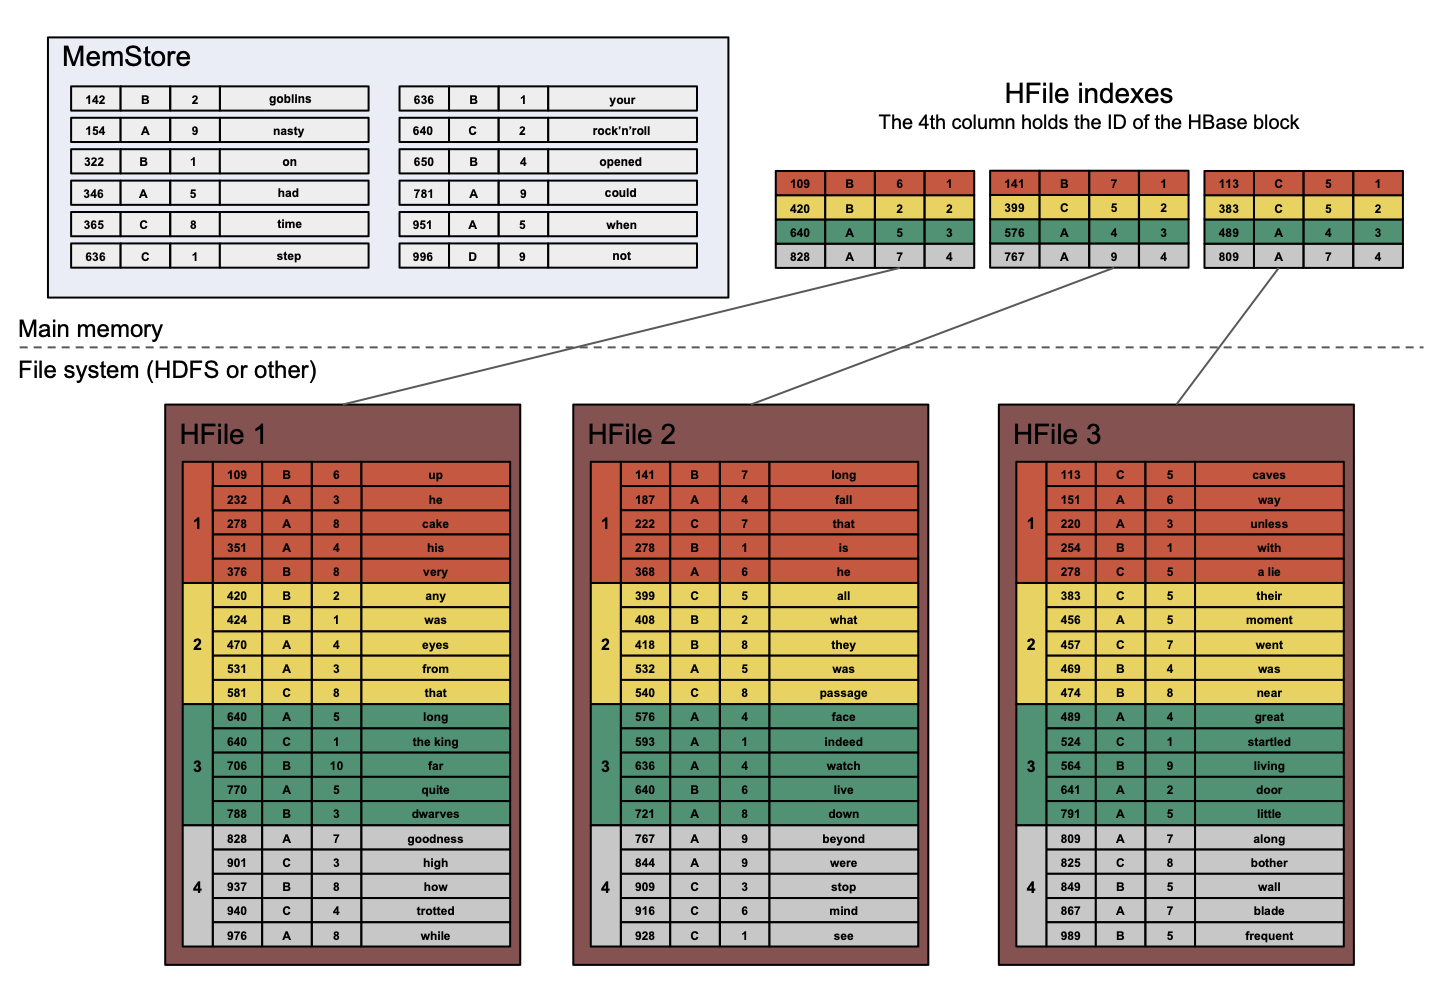

You can format your answer for this exercise as follows (doulbe-click to edit)

1. get 'phrases', 'row_id' 

| Row | Column | Timestamp | Value | Where it came from (which HFile) |
|:-----:|:-----:|:-----:|:-------|:--------------------:|
||||||
||||||
||||||

## Task 3.2 &mdash; Building an HFile index

In order to avoid scanning HFiles entirely, HBase uses index structures to quickly skip to the position of the *HBase block* which may hold the requested key. Note HBase block is not to be confused with HDFS block and the underlying file system block, see [here](https://blog.cloudera.com/hbase-blockcache-101/#3) for a good discussion.

By default, each *HBase block* is 64KB (but it is configurable) in size and always contains whole key-value pairs, so, if a block needs more than 64KB to avoid splitting a key-value pair, it will just grow. 

In this task, you will be building the index of an HFile. __For the purpose of this exercise__, assume that each HBase block is 40 bytes long, and each character in keys and values is worth 1 byte: for example, the first key-value pair in the diagram below is worth $3 + 1 + 1 + 6 = 11$ bytes.

<img src="https://polybox.ethz.ch/index.php/s/dx96DeKaYZN00L9/download" width="60%">

Based on the contents of the HFile above, you need to populate the index. First, calculate how the blocks will be "assembled", and then use the appropriate keys for the index.

You can use the following table (again, you can edit it by double-clicking). Use as many or as few rows as you need.

| RowId | Column | Version |
|-------|--------|---------|
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |